In [648]:
%matplotlib inline

import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import pymysql
import scipy.sparse as sps

from lightfm.data import Dataset
from lightfm import LightFM
from lightfm.evaluation import auc_score
from lightfm.cross_validation import random_train_test_split

In [649]:
db_connection_str = 'mysql+pymysql://root:123@db/invest'
db_connection = create_engine(db_connection_str)

df_clientes = pd.read_sql('SELECT * FROM cli_Clientes', con=db_connection)
df_cliente_produto = pd.read_sql('SELECT * FROM cli_Produtos', con=db_connection)
df_produtos = pd.read_sql('SELECT * FROM Produtos', con=db_connection)

In [650]:
df_cliente_produto.sample(2)

,userid,produtoid,valorrendimento,dataefetivacao
884,475,5972,NaN,2019-08-07
4909,1370,5386,NaN,2019-11-29


In [651]:
# removendo linhas com userid = 0 -> esses são os produtos que nenhum cliente comprou ainda

df_cliente_produto = df_cliente_produto[df_cliente_produto['userid'] > 0]

In [652]:
df_cliente_produto.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48333 entries, 0 to 48332
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   userid           48333 non-null  int64  
 1   produtoid        48333 non-null  int64  
 2   valorrendimento  7216 non-null   float64
 3   dataefetivacao   48272 non-null  object 
dtypes: float64(1), int64(2), object(1)
memory usage: 1.8+ MB


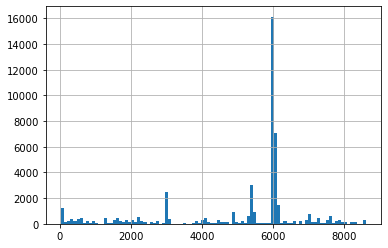

In [653]:
df_cliente_produto['produtoid'].hist(bins = 100)

In [654]:
# analisando os produtos mais populares
df_cliente_produto['produtoid'].value_counts()

5972    15397
6085     4470
5386     3011
6082     2001
6138     1331
        ...  
6106        1
6170        1
134         1
6266        1
5909        1
Name: produtoid, Length: 900, dtype: int64

In [655]:
# o produto mais popular
df_produtos[df_produtos['dataId'] == 5972]

,dataId,AdministradorFundo,AtivoDisponivel,Carencia,CarteiraCNPJ,CNPJAdministrador,DataDeVencimento,DescontoIR,DescricaoAtivo,DescricaoCarencia,...,TipoCarteira,TipoCota,TipoIndexador,TipoRegimeCondomonioCVM,Tributacao,ValorMinimoAplicacaoAdicional,ValorMinimoAplicaInicial,ValorMinimoResgate,ValorMinimo,Vencimento
5972,5972,SANTANDER SECURITIES SERVICES BRASIL DTVM S.A.,1,None,30.353.590/0001-05,03.502.968/0001-04,None,22.5,O FUNDO tem por objetivo investir em ativos fi...,Qualquer dia,...,Fundo de Renda Fixa,Abertura,None,Aberto,Longo prazo,30.0,30.0,30.0,NaN,None


In [656]:
# vendo os clientes que compraram mais vezes o produto mais popular
df_cliente_produto[df_cliente_produto['produtoid'] == 5972]['userid'].value_counts()

1369     36
736      27
462      22
566      21
2353     20
         ..
1076      1
11321     1
3133      1
1092      1
2049      1
Name: userid, Length: 6927, dtype: int64

In [657]:
# removendo os relacionamentos duplicados (clientes que compraram o mesmo produto mais de uma vez)
df_cliente_produto = df_cliente_produto[['userid','produtoid']].drop_duplicates()

In [658]:
df_cliente_produto.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30061 entries, 0 to 48332
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   userid     30061 non-null  int64
 1   produtoid  30061 non-null  int64
dtypes: int64(2)
memory usage: 704.6 KB


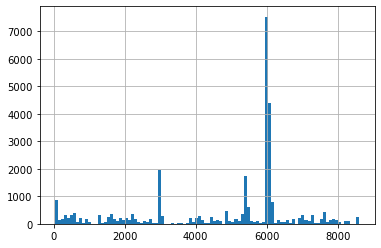

In [659]:
df_cliente_produto['produtoid'].hist(bins = 100)

In [660]:
df_clientes.sample(2)

,userid,userid_aux,idade,genero,estadocivil,billingcity,profissaopessoa,patrimonioautomoveis,patrimonioimoveis,patrimonioinvestimentos,...,nivelconhecimentoatual,scorenivelconhecimento,perfilinvestidor,rendamensal,valorpatrimonio,scorerisco,scoreobjetivos,scoresituacaofinanceira,createddate,dataclienteefetivado
482,483,$2b$10$.DCvvJ9WSDpqVP2xXjeSPePVXi6qOZ9ET3KI2oK...,52.5,M,C,Curitiba,Administrador,0.0,0.0,0.0,...,5.0,5.0,4,10000.0,700000.0,4.0,4.0,2.0,2019-06-22 11:20:19,2019-06-22 12:00:00
2640,2641,$2b$10$.DCvvJ9WSDpqVP2xXjeSPeYsjuUtvxCPXgbEtiV...,24.8,M,C,Belo Horizonte,Autônomo,0.0,0.0,0.0,...,1.0,1.0,2,1300.0,NaN,2.0,3.0,1.0,2019-08-29 08:07:38,2019-08-29 12:00:00


In [661]:
df_clientes.describe()

,userid,idade,patrimonioautomoveis,patrimonioimoveis,patrimonioinvestimentos,patrimoniooutros,nivelconhecimentoatual,scorenivelconhecimento,perfilinvestidor,rendamensal,valorpatrimonio,scorerisco,scoreobjetivos,scoresituacaofinanceira
count,14188.000000,14188.000000,13780.000000,13780.000000,13780.000000,13780.000000,13628.000000,14187.000000,14188.000000,1.418800e+04,9.498000e+03,14187.000000,14187.000000,14187.000000
mean,7094.500000,36.841303,2.819303,7.294630,8.126996,0.972424,2.453625,2.467893,2.760290,7.692467e+03,8.407910e+05,2.648411,3.065130,2.100092
std,4095.867145,11.037122,11.308762,20.933896,22.452113,6.901847,1.545563,1.548641,1.083585,2.425389e+04,1.567628e+07,1.105727,1.166216,1.036411
min,1.000000,18.100000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000e+00,0.000000e+00,1.000000,1.000000,1.000000
25%,3547.750000,28.700000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,2.000000,1.830000e+03,3.000000e+04,2.000000,2.000000,1.000000
50%,7094.500000,35.300000,0.000000,0.000000,0.000000,0.000000,2.000000,2.000000,3.000000,4.000000e+03,1.900000e+05,2.000000,3.000000,2.000000
75%,10641.250000,42.800000,0.000000,0.000000,0.000000,0.000000,4.000000,4.000000,4.000000,9.000000e+03,6.000000e+05,3.000000,4.000000,3.000000
max,14188.000000,96.200000,100.000000,100.000000,100.000000,100.000000,5.000000,5.000000,5.000000,2.400000e+06,1.500000e+09,5.000000,5.000000,5.000000


(array([2.300e+03, 3.872e+03, 4.011e+03, 2.154e+03, 1.050e+03, 5.170e+02,
        2.110e+02, 5.700e+01, 1.300e+01, 3.000e+00]),
 array([18.1 , 25.91, 33.72, 41.53, 49.34, 57.15, 64.96, 72.77, 80.58,
        88.39, 96.2 ]),
 <a list of 10 Patch objects>)

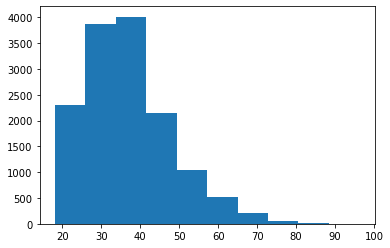

In [662]:
plt.hist(df_clientes['idade'])

In [663]:
df_clientes['idade'] = pd.cut(df_clientes['idade'], bins=[0,20,35,65,100], labels=["jovem", "jovemadulto", "adulto", "idoso"])

(array([6704.,    0.,    0., 6963.,    0.,    0.,  240.,    0.,    0.,
         281.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 10 Patch objects>)

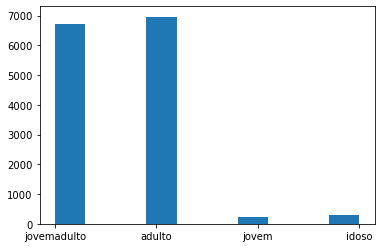

In [664]:
plt.hist(df_clientes['idade'])

In [665]:
df_produtos.sample(2)

,dataId,AdministradorFundo,AtivoDisponivel,Carencia,CarteiraCNPJ,CNPJAdministrador,DataDeVencimento,DescontoIR,DescricaoAtivo,DescricaoCarencia,...,TipoCarteira,TipoCota,TipoIndexador,TipoRegimeCondomonioCVM,Tributacao,ValorMinimoAplicacaoAdicional,ValorMinimoAplicaInicial,ValorMinimoResgate,ValorMinimo,Vencimento
745,745,None,0,2020-07-24,None,None,2020-07-24,22.5,"O Certificado de Depósito Bancário, de forma s...",No venc.,...,None,None,Pré fixado,None,None,NaN,NaN,NaN,1000.0,2020-07-24
7730,7730,Santander Securities Services Brtasil DTVM SA,1,None,14.237.118/0001-42,03.502.968/0001-04,None,22.5,O Fundo busca gerar retornos consistentes e su...,Qualquer dia,...,FIC de Fundo Multimercado,Fechamento,None,Aberto,Longo prazo,5000.0,5000.0,5000.0,NaN,None


In [672]:
# selecionando as features do dataset de clientes a serem utilizadas
df_clientes_features = df_clientes[['userid', 'idade', 'perfilinvestidor', 'scoresituacaofinanceira', 'scorenivelconhecimento']]
df_clientes_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14188 entries, 0 to 14187
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   userid                   14188 non-null  int64   
 1   idade                    14188 non-null  category
 2   perfilinvestidor         14188 non-null  int64   
 3   scoresituacaofinanceira  14187 non-null  float64 
 4   scorenivelconhecimento   14187 non-null  float64 
dtypes: category(1), float64(2), int64(2)
memory usage: 457.5 KB


In [673]:
df_clientes_features.loc[:, 'perfilinvestidor'] = 'perfil' + df_clientes_features['perfilinvestidor'].map(str)
df_clientes_features.loc[:, 'scoresituacaofinanceira'] = 'scoresf' + df_clientes_features['scoresituacaofinanceira'].map(str)
df_clientes_features.loc[:, 'scorenivelconhecimento'] = 'scorenc' + df_clientes_features['scorenivelconhecimento'].map(str)
df_clientes_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14188 entries, 0 to 14187
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   userid                   14188 non-null  int64   
 1   idade                    14188 non-null  category
 2   perfilinvestidor         14188 non-null  object  
 3   scoresituacaofinanceira  14188 non-null  object  
 4   scorenivelconhecimento   14188 non-null  object  
dtypes: category(1), int64(1), object(3)
memory usage: 457.5+ KB


In [674]:
df_clientes_features

,userid,idade,perfilinvestidor,scoresituacaofinanceira,scorenivelconhecimento
0,1,jovemadulto,perfil4,scoresf4.0,scorenc2.0
1,2,jovemadulto,perfil2,scoresf2.0,scorenc1.0
2,3,adulto,perfil1,scoresf1.0,scorenc2.0
3,4,adulto,perfil3,scoresf2.0,scorenc4.0
4,5,jovemadulto,perfil2,scoresf2.0,scorenc1.0
...,...,...,...,...,...
14183,14184,jovemadulto,perfil2,scoresf4.0,scorenc2.0
14184,14185,jovemadulto,perfil2,scoresf3.0,scorenc1.0
14185,14186,adulto,perfil2,scoresf1.0,scorenc1.0
14186,14187,jovemadulto,perfil2,scoresf2.0,scorenc3.0


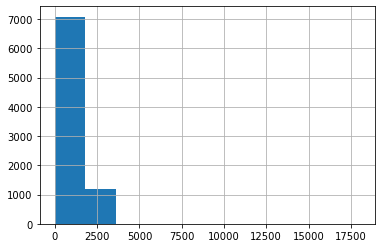

In [675]:
df_produtos['PrazoDias'].hist(bins = 10)

In [676]:
df_produtos['PrazoDias'] = pd.cut(df_produtos['PrazoDias'], bins=[0,731,1250,4000], labels=["curtoPrazo", "medioPrazo", "longoPrazo"])

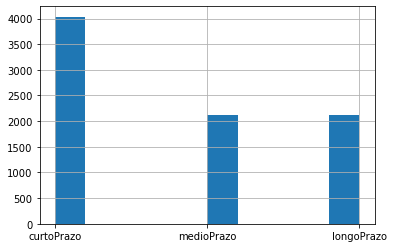

In [677]:
df_produtos['PrazoDias'].hist()

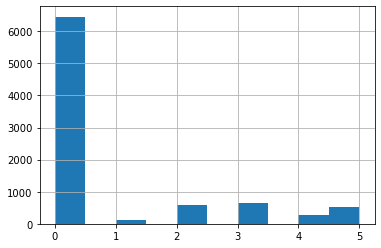

In [678]:
df_produtos['RiscoAtivo'].hist()

In [679]:
df_produtos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8603 entries, 0 to 8602
Data columns (total 86 columns):
 #   Column                             Non-Null Count  Dtype   
---  ------                             --------------  -----   
 0   dataId                             8603 non-null   int64   
 1   AdministradorFundo                 320 non-null    object  
 2   AtivoDisponivel                    8603 non-null   int64   
 3   Carencia                           8282 non-null   object  
 4   CarteiraCNPJ                       320 non-null    object  
 5   CNPJAdministrador                  320 non-null    object  
 6   DataDeVencimento                   8282 non-null   object  
 7   DescontoIR                         8603 non-null   float64 
 8   DescricaoAtivo                     8593 non-null   object  
 9   DescricaoCarencia                  8603 non-null   object  
 10  DescricaoClasse                    8282 non-null   object  
 11  DescricaoCotizacaoAplicacao        8603 non

In [680]:
# selecionando as features do dataset de produtos a serem utilizadas
df_produtos_features = df_produtos[['dataId', 
                                    'PrazoDias', 
                                    'ResgateDias', 
                                    'RiscoAtivo', 
                                    'SeFGCAtivo', 
                                    'DescricaoTributacao',
                                    'DescricaoLiquidacaoResgate']]
df_produtos_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8603 entries, 0 to 8602
Data columns (total 7 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   dataId                      8603 non-null   int64   
 1   PrazoDias                   8278 non-null   category
 2   ResgateDias                 8603 non-null   object  
 3   RiscoAtivo                  8602 non-null   float64 
 4   SeFGCAtivo                  8603 non-null   int64   
 5   DescricaoTributacao         8603 non-null   object  
 6   DescricaoLiquidacaoResgate  8603 non-null   object  
dtypes: category(1), float64(1), int64(2), object(3)
memory usage: 411.9+ KB


In [682]:
df_produtos_features.loc[:,'PrazoDias'] = df_produtos_features['PrazoDias'].fillna('curtoPrazo')
df_produtos_features.loc[:,'RiscoAtivo'] = df_produtos_features['RiscoAtivo'].fillna('0')
df_produtos_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8603 entries, 0 to 8602
Data columns (total 7 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   dataId                      8603 non-null   int64   
 1   PrazoDias                   8603 non-null   category
 2   ResgateDias                 8603 non-null   object  
 3   RiscoAtivo                  8603 non-null   object  
 4   SeFGCAtivo                  8603 non-null   int64   
 5   DescricaoTributacao         8603 non-null   object  
 6   DescricaoLiquidacaoResgate  8603 non-null   object  
dtypes: category(1), int64(2), object(4)
memory usage: 411.9+ KB


In [683]:
df_produtos_features.loc[:, 'RiscoAtivo'] = 'Risco' + df_produtos_features['RiscoAtivo'].map(str)
df_produtos_features.loc[:, 'SeFGCAtivo'] = 'FGCAtivo' + df_produtos_features['SeFGCAtivo'].map(str)
df_produtos_features

,dataId,PrazoDias,ResgateDias,RiscoAtivo,SeFGCAtivo,DescricaoTributacao,DescricaoLiquidacaoResgate
0,0,curtoPrazo,No venc.,Risco0.0,FGCAtivo1,15%,No dia
1,1,medioPrazo,No venc.,Risco0.0,FGCAtivo1,15%,No dia
2,2,medioPrazo,No venc.,Risco0.0,FGCAtivo1,15%,No dia
3,3,longoPrazo,No venc.,Risco0.0,FGCAtivo1,15%,No dia
4,4,curtoPrazo,No venc.,Risco0.0,FGCAtivo1,15%,No dia
...,...,...,...,...,...,...,...
8598,8598,curtoPrazo,No venc.,Risco0.0,FGCAtivo1,15%,No dia
8599,8599,medioPrazo,No venc.,Risco0.0,FGCAtivo1,15%,No dia
8600,8600,longoPrazo,No venc.,Risco0.0,FGCAtivo1,15%,No dia
8601,8601,longoPrazo,No venc.,Risco5.0,FGCAtivo1,15%,No dia


In [684]:
dataset = Dataset(user_identity_features=False, 
                  item_identity_features=False)
dataset.fit((x for x in df_clientes['userid'].unique()),
            (x for x in df_produtos['dataId'].unique()), 
            user_features=df_clientes_features.drop('userid', axis=1).values.ravel(),
            item_features=df_produtos_features.drop('dataId', axis=1).values.ravel())

In [685]:
num_users, num_items = dataset.interactions_shape()
print('Num users: {}, num_items {}.'.format(num_users, num_items))

Num users: 14188, num_items 8603.


In [686]:
# Construindo a matriz de interações
(interactions, weights) = dataset.build_interactions(((x[0], x[1]) for x in df_cliente_produto.values))

print(repr(interactions))

<14188x8603 sparse matrix of type '<class 'numpy.int32'>'
	with 30061 stored elements in COOrdinate format>


In [688]:
user_features = dataset.build_user_features(((x[0], [x[1], x[2], x[3], x[4]])
                                              for x in df_clientes_features.values))
print(repr(user_features))

<14188x21 sparse matrix of type '<class 'numpy.float32'>'
	with 56752 stored elements in Compressed Sparse Row format>


In [690]:
item_features = dataset.build_item_features(((x[0], [x[1], x[2], x[3], x[4], x[5], x[6]])
                                              for x in df_produtos_features.values))
print(repr(item_features))

<8603x23 sparse matrix of type '<class 'numpy.float32'>'
	with 51618 stored elements in Compressed Sparse Row format>


In [691]:
user_id_map, user_feature_map, item_id_map, item_feature_map = dataset.mapping()

In [692]:
user_feature_map

{'jovemadulto': 0,
 'perfil4': 1,
 'scoresf4.0': 2,
 'scorenc2.0': 3,
 'perfil2': 4,
 'scoresf2.0': 5,
 'scorenc1.0': 6,
 'adulto': 7,
 'perfil1': 8,
 'scoresf1.0': 9,
 'perfil3': 10,
 'scorenc4.0': 11,
 'scoresf3.0': 12,
 'scorenc5.0': 13,
 'scorenc3.0': 14,
 'perfil5': 15,
 'jovem': 16,
 'idoso': 17,
 'scoresf5.0': 18,
 'scoresfnan': 19,
 'scorencnan': 20}

In [693]:
item_feature_map

{'curtoPrazo': 0,
 'No venc.': 1,
 'Risco0.0': 2,
 'FGCAtivo1': 3,
 '15%': 4,
 'No dia': 5,
 'medioPrazo': 6,
 'longoPrazo': 7,
 'Risco3.0': 8,
 'Qualquer dia': 9,
 'Risco5.0': 10,
 'FGCAtivo0': 11,
 '2 Dias úteis': 12,
 'Risco2.0': 13,
 'Risco4.0': 14,
 'Risco1.0': 15,
 'Come Cotas': 16,
 '1 Dia útil': 17,
 '5 Dias úteis': 18,
 '3 Dias úteis': 19,
 'Com carência': 20,
 'Risco0': 21,
 '4 Dias úteis': 22}

In [694]:
# dividindo o dataset em treino e teste

interactions_train, interactions_test = random_train_test_split(
    interactions, 
    test_percentage=0.2, 
    random_state=np.random.RandomState(2020)
)

In [695]:
# treinando o modelo
model = LightFM(
    no_components=10,
    learning_rate=0.05,
    loss='warp',
    random_state=2019)

model = model.fit(interactions_train,
                  user_features=user_features,
                  epochs=10,
                  num_threads=16, verbose=True)

Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9


In [696]:
auc_score(model, 
          interactions_train, 
          user_features=user_features, 
          num_threads=4).mean()

0.99614865

In [697]:
auc_score(model, 
          interactions_test, 
          user_features=user_features, 
          train_interactions=interactions_train, 
          num_threads=4).mean()

0.9908552

In [698]:
def sample_recommendation_new_user(model, interactions, user_feature_map, new_user_features, 
                                   item_dict, nrec_items = 5):
    
    target_indices = []
    for feature in new_user_features:
        target_indices.append(user_feature_map[feature])

    features = np.zeros(len(user_feature_map.keys()))
    for i in target_indices:
        features[i] = 1
    features = sps.csr_matrix(features)

    n_users, n_items = interactions.shape
    scores = pd.Series(model.predict(0, np.arange(num_items), 
                                     user_features=features, item_features=item_features))
    scores.index = list(item_id_map.values())
    scores = list(pd.Series(scores.sort_values(ascending=False).index))

    return_score_list = scores[0:nrec_items]
    inv_item_id_map = {v: k for k, v in item_dict.items()}
    scores = list(pd.Series(return_score_list).apply(lambda x: inv_item_id_map[x]))
    
    print ("Novo Usuario")
    print("\nProdutos Recomendados:")
    counter = 1
    for i in scores:
        print(str(counter) + '- ' + str(i))
        counter+=1

In [699]:
new_user_feature_list = ['idoso', 'perfil5', 'scoresf5.0', 'scorenc5.0' ] 

sample_recommendation_new_user(model, interactions, user_feature_map, new_user_feature_list, item_id_map)

Novo Usuario

Produtos Recomendados:
1- 2731
2- 5780
3- 5189
4- 6167
5- 8393


In [587]:
def sample_recommendation_user(model, interactions, user_id, user_dict, 
                               item_dict, nrec_items = 5):
    
    n_users, n_items = interactions.shape
    user_x = user_dict[user_id]
    scores = pd.Series(model.predict(user_x, np.arange(n_items)))#, item_features=books_metadata_csr))
    scores.index = list(item_id_map.values())
    scores = list(pd.Series(scores.sort_values(ascending=False).index))
    
    user_items = list(df_cliente_produto[df_cliente_produto['userid'] == user_id]['produtoid'].values)
    user_items_indexes = list(pd.Series(user_items).apply(lambda x: item_id_map[x]))

    scores = [x for x in scores if x not in user_items_indexes]
    return_score_list = scores[0:nrec_items]
    inv_item_id_map = {v: k for k, v in item_dict.items()}
    scores = list(pd.Series(return_score_list).apply(lambda x: inv_item_id_map[x]))
    
    print ("Usuario: " + str(user_id))
    print("Produtos já adquiridos:")
    counter = 1
    for i in user_items:
        print(str(counter) + '- ' + str(i))
        counter+=1
    print("\nProdutos Recomendados:")
    counter = 1
    for i in scores:
        print(str(counter) + '- ' + str(i))
        counter+=1

In [588]:
sample_recommendation_user(model, interactions, 5, user_id_map, item_id_map)

Usuario: 5
Produtos já adquiridos:
1- 6085
2- 6082

Produtos Recomendados:
1- 5972
2- 5386
3- 5470
4- 6138
5- 6014
